## Floods dataset exploration

In [4]:
from datetime import datetime
import numpy as np
import pandas as pd
import rasterio
import os

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

### Read in all the data

In [2]:
root_dir = '/home/k3blu3/datasets/s1floods'
meta_file = 'flood-training-metadata.csv'
image_dir = os.path.join(root_dir, 'train_features')
label_dir = os.path.join(root_dir, 'train_labels')

In [5]:
df = pd.read_csv(os.path.join(root_dir, meta_file))
df.head(5)

,image_id,chip_id,flood_id,polarization,location,scene_start
0,awc00_vh,awc00,awc,vh,Bolivia,2018-02-15
1,awc00_vv,awc00,awc,vv,Bolivia,2018-02-15
2,awc01_vh,awc01,awc,vh,Bolivia,2018-02-15
3,awc01_vv,awc01,awc,vv,Bolivia,2018-02-15
4,awc02_vh,awc02,awc,vh,Bolivia,2018-02-15


In [6]:
# define all image types per chip id
extensions = ['vv', 'vh', 'nasadem', 'jrc-gsw-occurrence']

In [7]:
# keep unique chip ids
df= df.drop_duplicates(subset=['chip_id'])

In [9]:
data_stack = list()
for idx, row in tqdm(df.iterrows(), total=len(df)):
    layers = list()
    for ext in extensions:
        fname = os.path.join(image_dir, f"{row['chip_id']}_{ext}.tif")
        with rasterio.open(fname) as src:
            layer = src.read(1, masked=True)
            layers.append(layer)
    
    layers = np.ma.stack(layers, axis=-1)
    
    data_stack.append(layers)
    
data_stack = np.ma.stack(data_stack, axis=0)

  0%|          | 0/542 [00:00<?, ?it/s]

In [57]:
data_stack[:, :, :, 3].std()

34.480693749502656

### Plot histograms of all the bands

In [58]:
hist_stack = list()
bin_stack = list()
n_bins = 25
ranges = [(-50, 0), (-50, 0), (0, 500), (0, 100)]
for eidx, ext in tqdm(enumerate(extensions), total=len(extensions)):
    ext_data = data_stack[:, :, :, eidx]
    hist, bins = np.histogram(ext_data.compressed(), n_bins, ranges[eidx])
    hist_stack.append(hist)
    bin_stack.append(bins)
    
hist_stack = np.stack(hist_stack, axis=0)
bin_stack = np.stack(bin_stack, axis=0)

  0%|          | 0/4 [00:00<?, ?it/s]

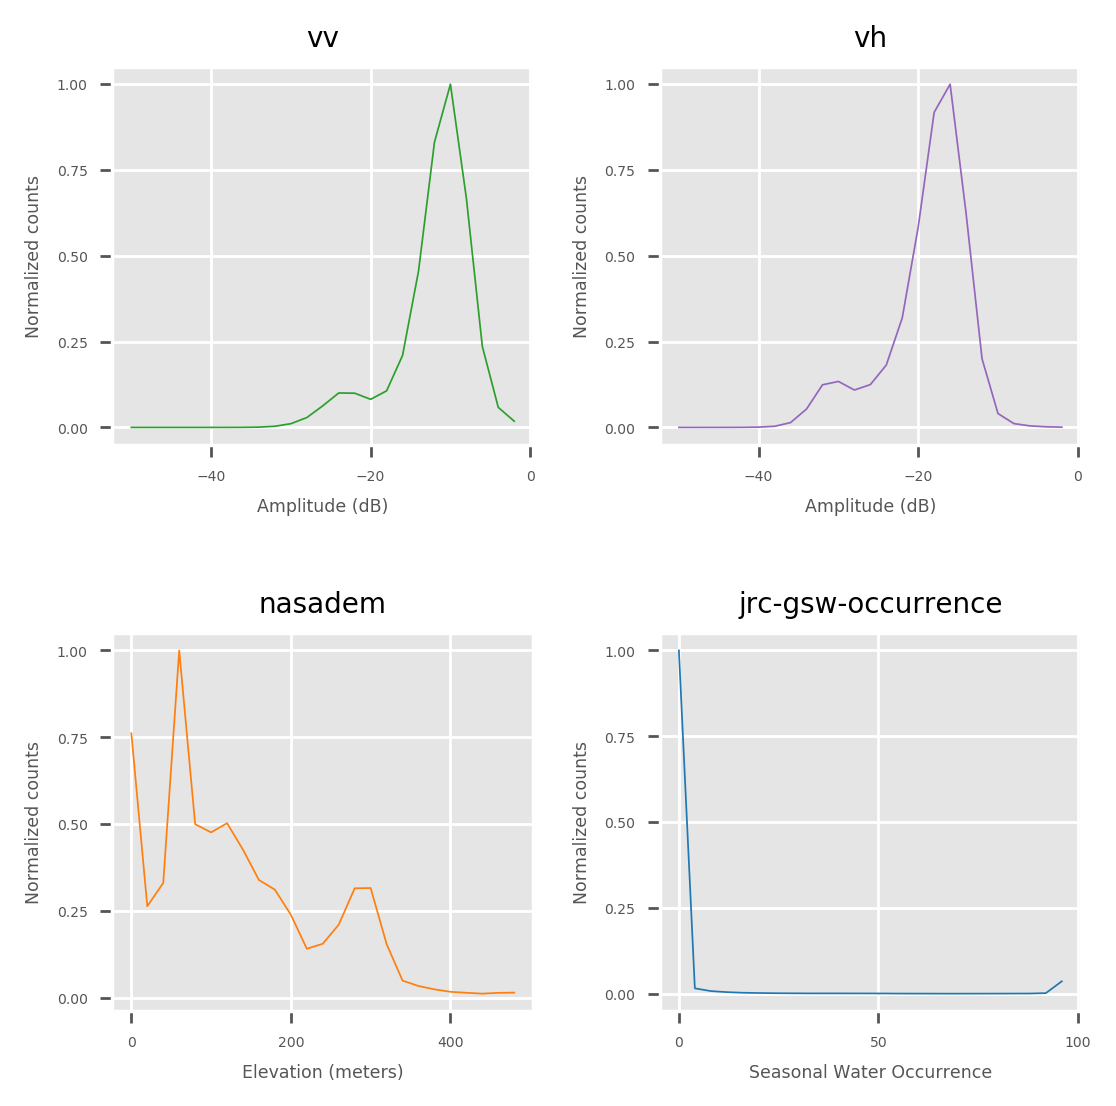

In [65]:
plt.figure(dpi=250, figsize=(5, 5))
plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.style.use('ggplot')
colors = ['tab:green', 'tab:purple', 'tab:orange', 'tab:blue']

plt.subplot(2, 2, 1)
plt.plot(bin_stack[0, :-1], hist_stack[0, :]/hist_stack[0, :].max(), linewidth=0.5, color=colors[0])
plt.title(extensions[0], fontsize=8)
plt.xlabel('Amplitude (dB)', fontsize=5)
plt.ylabel('Normalized counts', fontsize=5)
plt.xticks(fontsize=4)
plt.yticks(fontsize=4)

plt.subplot(2, 2, 2)
plt.plot(bin_stack[1, :-1], hist_stack[1, :]/hist_stack[1, :].max(), linewidth=0.5, color=colors[1])
plt.title(extensions[1], fontsize=8)
plt.xlabel('Amplitude (dB)', fontsize=5)
plt.ylabel('Normalized counts', fontsize=5)
plt.xticks(fontsize=4)
plt.yticks(fontsize=4)

plt.subplot(2, 2, 3)
plt.plot(bin_stack[2, :-1], hist_stack[2, :]/hist_stack[2, :].max(), linewidth=0.5, color=colors[2])
plt.title(extensions[2], fontsize=8)
plt.xlabel('Elevation (meters)', fontsize=5)
plt.ylabel('Normalized counts', fontsize=5)
plt.xticks(fontsize=4)
plt.yticks(fontsize=4)

plt.subplot(2, 2, 4)
plt.plot(bin_stack[3, :-1], hist_stack[3, :]/hist_stack[3, :].max(), linewidth=0.5, color=colors[3])
plt.title(extensions[3], fontsize=8)
plt.xlabel('Seasonal Water Occurrence', fontsize=5)
plt.ylabel('Normalized counts', fontsize=5)
plt.xticks(fontsize=4)
plt.yticks(fontsize=4)

plt.show()
#plt.savefig('hist.jpg', bbox_inches='tight')
plt.close()